In [93]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64

from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [94]:
def hrp(returns):
    def correl_dist(corr):
        # A distance matrix based on correlation, where 0<=d[i,j]<=1
        # This is a proper distance metric
        dist = ((1 - corr) / 2.)**.5  # distance matrix
        dist = squareform(dist)
        return dist

    def get_quasi_diag(link):
        # Sort clustered items by distance
        link = link.astype(int)
        sortIx = pd.Series([link[-1, 0], link[-1, 1]])
        numItems = link[-1, 3]  # number of original items
        while sortIx.max() >= numItems:
            sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
            df0 = sortIx[sortIx >= numItems]  # find clusters
            i = df0.index
            j = df0.values - numItems
            sortIx[i] = link[j, 0]  # item 1
            df1 = pd.Series(link[j, 1], index=(i + 1).tolist())
            sortIx = pd.concat([sortIx, df1]).sort_index()
            sortIx.index = range(sortIx.shape[0])
        return sortIx.tolist()

    def get_cluster_var(cov, cItems):
        # Compute variance per cluster
        cov_= cov.loc[cItems,cItems] # matrix slice
        # Compute the inverse_variance portfolio
        ivp = 1. / np.diag(cov_)
        ivp /= ivp.sum()
        w_= ivp.reshape(-1,1)
        cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
        return cVar

    def get_rec_bipart(cov, sortIx):
        # Compute HRP alloc
        w = pd.Series(1, index=sortIx)
        cItems = [sortIx]  # initialize all items in one cluster
        while len(cItems) > 0:
            cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
            for i in range(0, len(cItems), 2):  # parse in pairs
                cItems0 = cItems[i]  # cluster 1
                cItems1 = cItems[i + 1]  # cluster 2
                cVar0 = get_cluster_var(cov, cItems0)
                cVar1 = get_cluster_var(cov, cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha  # weight 1
                w[cItems1] *= 1 - alpha  # weight 2
        return w
    
    cov, corr = returns.cov(), returns.corr()
    # Construct a hierarchical portfolio
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = get_rec_bipart(cov, sortIx)
    return hrp.sort_index().values

def ivp(returns):
    # Compute the inverse-variance portfolio
    cov = returns.cov()
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ewp(returns):
    weight = 1/len(returns.columns)
    return np.full(len(returns.columns), weight)

def mvp(returns):
    cov = returns.cov()
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(list(wt))

In [95]:
def port_opt(data, window_size, port_opt_func, option):
    assert port_opt_func==ewp or port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp, 'Must use callable function ewp, hrp, mvp, or ivp'
    @ray.remote
    def exec_port_opt(i, data, window_size, port_opt_func, option):
        if option == 'long':  
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_weights = port_opt_func(long_returns)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights)
        elif option == 'short':
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_weights = port_opt_func(short_returns)
            total_ret = np.sum(short_returns.iloc[-1] * short_weights)
        elif option == 'both':
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_weights = port_opt_func(long_returns)
            
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_weights = port_opt_func(short_returns)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights) + np.sum(short_returns.iloc[-1] * short_weights)
        
        return total_ret
    
    if port_opt_func == ewp:
        if option == 'long':
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns)
            long_weights = np.tile(long_weights, (len(long_returns), 1))
            total_ret = np.sum(long_returns.values * long_weights, axis=1)
        elif option == 'short':
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns)
            short_weights = np.tile(short_weights, (len(short_returns), 1))
            total_ret = np.sum(short_returns.values * short_weights, axis=1)
        elif option == 'both':
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns)
            long_weights = np.tile(long_weights, (len(long_returns), 1))

            short_returns = -1 * pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns)
            short_weights = np.tile(short_weights, (len(short_returns), 1))
            total_ret = np.sum(long_returns.values * long_weights, axis=1) + np.sum(short_returns.values * short_weights, axis=1)
        data['totalRet'] = total_ret
        return data
    
    ray.init(num_cpus=16, ignore_reinit_error=True)
    start_time = time.time()
    total_ret_collect = ray.get([exec_port_opt.remote(i, data, window_size, port_opt_func, option) for i in range(0, len(data) - window_size + 1)])
    end_time = time.time()
    elapsed_time = end_time - start_time
    rounded_time = round(elapsed_time, 2)
    print(f"Elapsed time: {rounded_time} seconds")
    ray.shutdown()
    
    data = data[window_size-1:]
    data['totalRet'] = total_ret_collect
    return data 

In [96]:
stock = read_stock(get_load_data_large_dir() / 'permno_to_train_fund.csv')
start = '2010-01-01'
end = '2023-01-01'

In [97]:
etf = pd.read_parquet(get_factor_data_dir() / 'factor_sb_sector.parquet.brotli')

In [98]:
etf = pd.read_parquet(get_factor_data_dir() / 'factor_sb_sector.parquet.brotli')
ep_col = [col for col in etf.columns if col.startswith('epsil')]
pred_col = [col for col in etf.columns if col.startswith('pred')]
alpha_col = [col for col in etf.columns if col.startswith('ALPHA')]
etf = etf[[ep_col[1], pred_col[1], alpha_col[1]]]
etf.columns = ['epsil', 'pred', 'alpha']
etf['beta'] = etf['pred'] - etf['alpha']
etf = etf[['epsil', 'beta']]

<AxesSubplot:xlabel='permno,date'>

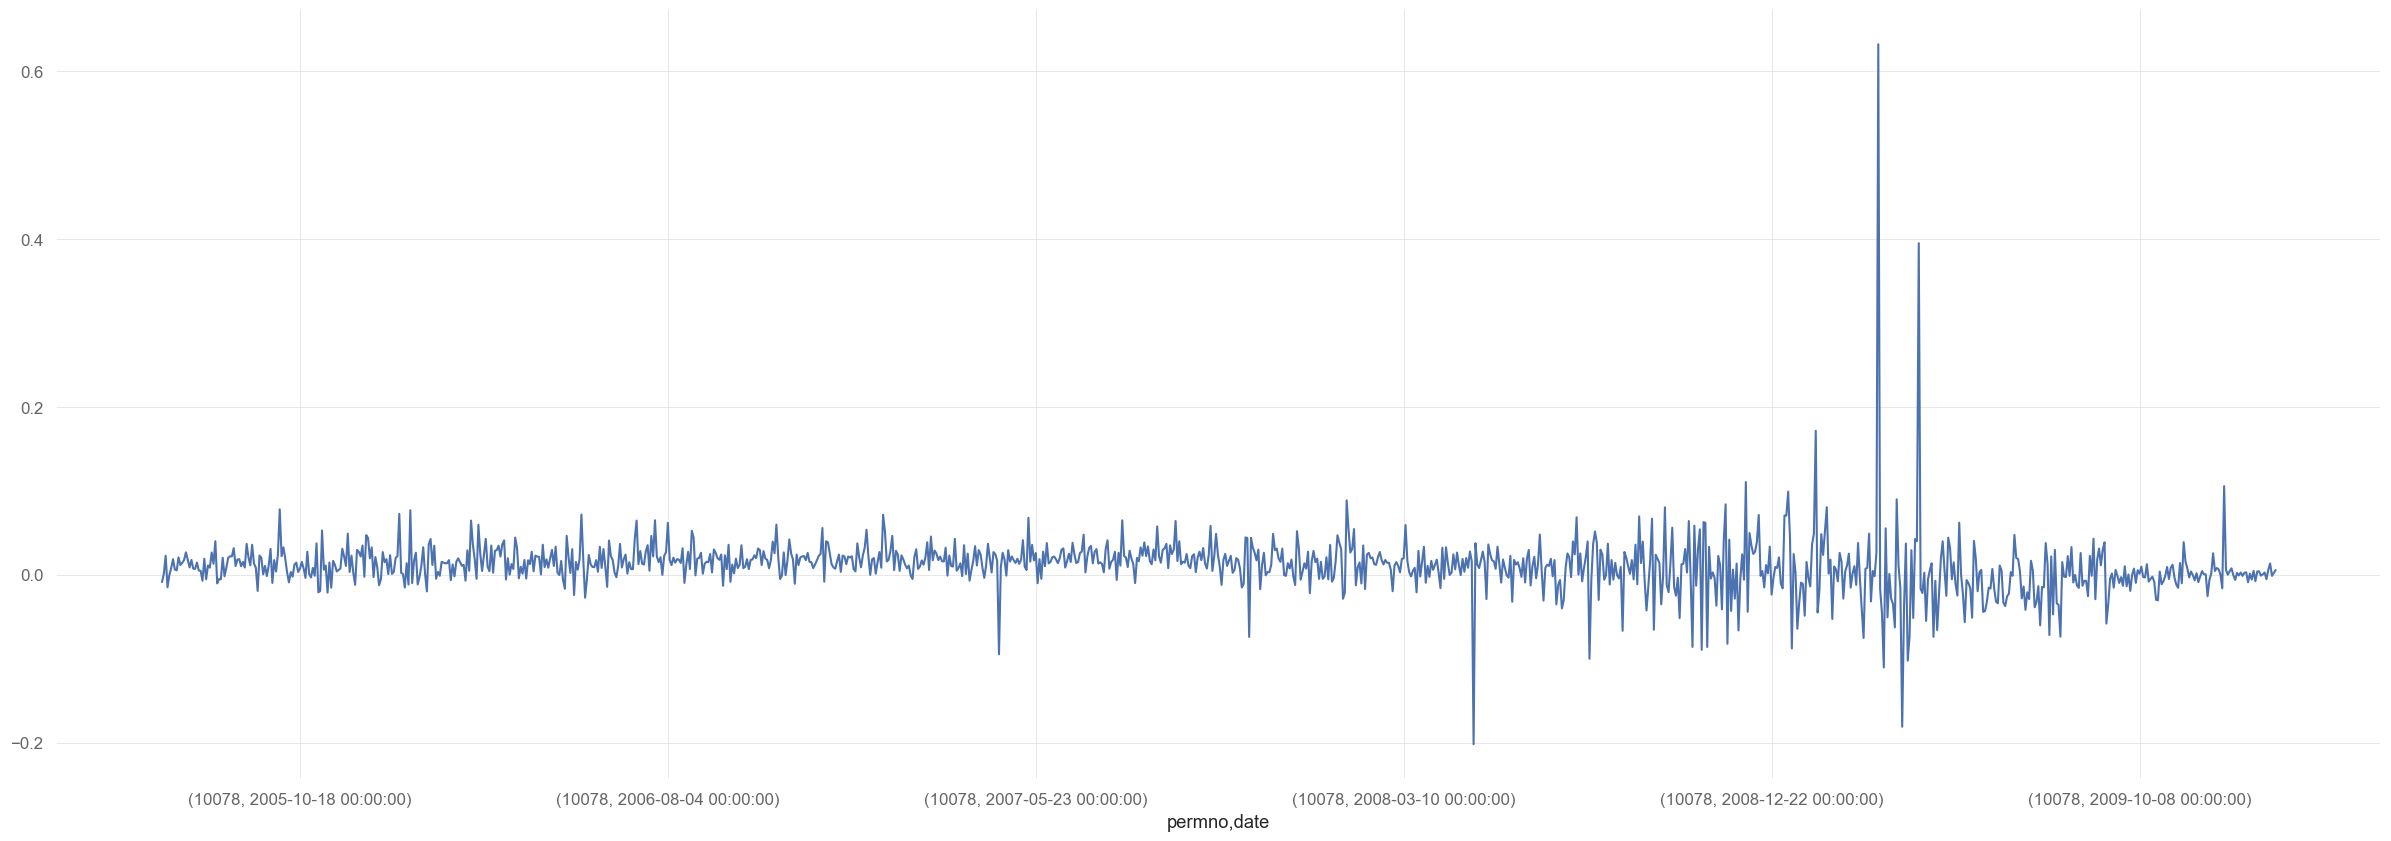

In [99]:
get_stock_data(etf, 10078).epsil.plot(figsize=(30,10))

In [100]:
ret = PrepFactor(factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()
ret = ret[['RET_01']]
ret.columns = ['returns']
ret['returns'] = ret.groupby('permno')['returns'].shift(-1)

Creating factor_ret ---------------------------------------- | ✔
Shape: (2731395, 5)


In [101]:
merged = ret.merge(etf, left_index=True, right_index=True, how='left')

# Convert to ticker

In [102]:
ticker = pd.read_parquet(get_load_data_parquet_dir() / 'data_ticker.parquet.brotli')
tic = merged.merge(ticker, left_index=True, right_index=True, how='left')
tic['window'] = tic.index.get_level_values('date').year - tic.index.get_level_values('date').year.min()
tic = tic.reset_index().set_index(['window', 'ticker', 'date'])
tic = tic.drop('permno', axis=1)

# Backtest

In [103]:
def sscore(Xi, mi, sigma_i, kappa_i):
    sigma_eq_i = sigma_i * (2 * kappa_i) ** 0.5
    s_score = (Xi - mi) / sigma_eq_i
    return s_score
    
def action(si):
    # Define the cutoff values
    sbo = 1.25  # Buy to open
    sso = 1.25  # Sell to open
    sbc = 0.75  # Close short position
    ssc = 0.50  # Close long position

    action = None  # Define action: "buy", "sell", "close buy", "close sell", or None

    if si < -sbo:
        action = "b"
    elif si > sso:
        action = "s"
    elif si < sbc:
        action = "cs"
    elif si > -ssc:
        action = "cb"
    return action

def calculate_daily_returns(df):    
    df['totalRet'] = 0
    df['totalRet'] = df['totalRet'] - df['beta']

    # Adjust portfolio_return based on the action
    df.loc[df['action'] == 'b', 'totalRet'] += df['returns']
    df.loc[df['action'] == 's', 'totalRet'] -= df['returns']
    
    # Closing positions
    df.loc[df['action'] == 'cb', 'totalRet'] -= df['returns']
    df.loc[df['action'] == 'cs', 'totalRet'] += df['returns']
    return df

def backtest(stock_subset):
    mi = stock_subset['epsil'].mean()
    sigma_i = stock_subset['epsil'].std()
    kappa_i = 0.01

    stock_subset['s_score'] = (stock_subset['epsil'] - mi) / (sigma_i * (2 * kappa_i) ** 0.5)
    stock_subset['action'] = stock_subset['s_score'].apply(action)
    
    return calculate_daily_returns(stock_subset)

In [104]:
total = [backtest(merged.loc[permno]) for permno in merged.index.get_level_values('permno').unique()]
port_ret = pd.concat(total)

In [105]:
pred_return = port_ret.groupby('date')['totalRet'].mean().to_frame()

In [106]:
pred_return

,totalRet
date,
2010-01-04,-0.018676
2010-01-05,-0.006124
2010-01-06,-0.005345
2010-01-07,-0.005200
2010-01-08,-0.006337
...,...
2022-12-22,0.014601
2022-12-23,-0.007644
2022-12-27,0.013306


# Calculate Total Returns

## Long

In [107]:
#Get SPY returns (matching timeframe as our backtest)
spy_return = get_spy(start_date=pred_return.index[0]-timedelta(days=1), end_date=pred_return.index[-1]+timedelta(days=1))
spy = spy_return['spyRet']

[*********************100%%**********************]  1 of 1 completed


## Both

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-05   2010-01-05
End Period                 2022-12-28   2022-12-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          232.36%      -68.06%
CAGR﹪                     6.59%        -5.89%

Sharpe                     0.61         -0.34
Prob. Sharpe Ratio         98.54%       11.25%
Smart Sharpe               0.51         -0.28
Sortino                    0.85         -0.5
Smart Sortino              0.71         -0.41
Sortino/√2                 0.6          -0.35
Smart Sortino/√2           0.5          -0.29
Omega                      0.94         0.94

Max Drawdown               -34.1%       -73.02%
Longest DD Days            417          4558
Volatility (ann.)          17.67%       20.02%
R^2                        0.84         0.84
Information Ratio          -0.03        -0.03
Calmar     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2010-07-07,2022-11-30,2022-12-28,4558,-73.023898,-72.259032
2,2010-02-09,2010-04-26,2010-07-01,143,-13.555979,-13.058935
3,2010-02-01,2010-02-03,2010-02-03,3,-3.253404,-2.600683
4,2010-01-06,2010-01-19,2010-01-20,15,-1.987799,-1.947840
5,2010-01-25,2010-01-27,2010-01-28,4,-0.980436,-0.806214


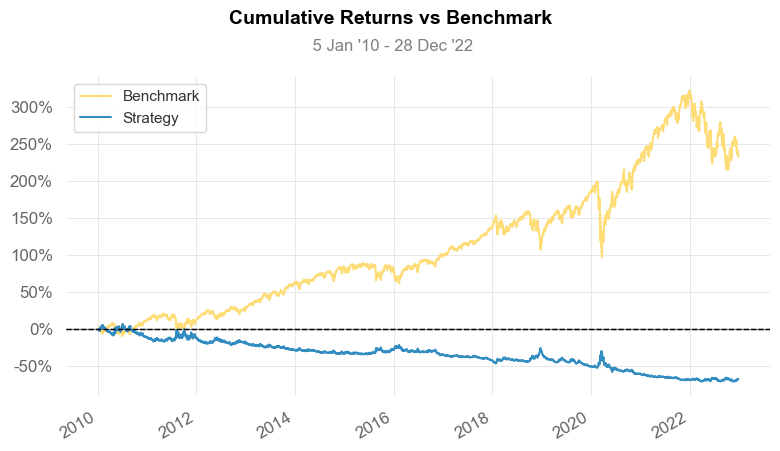

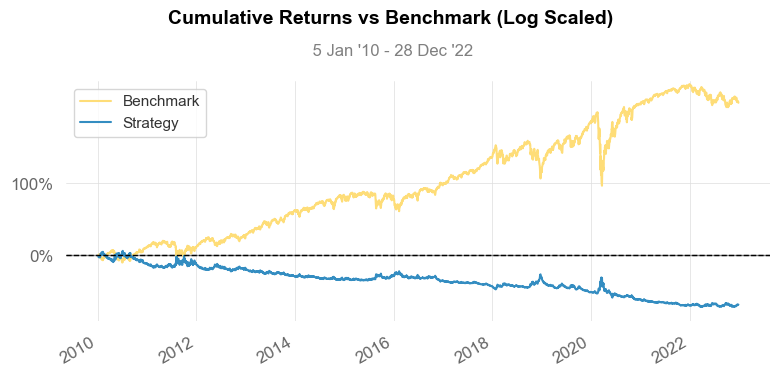

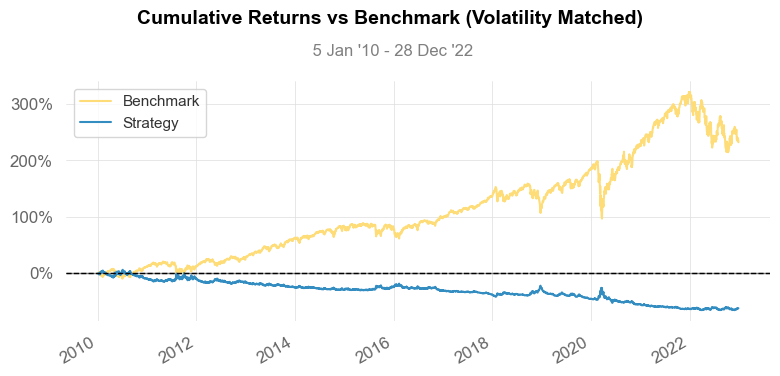

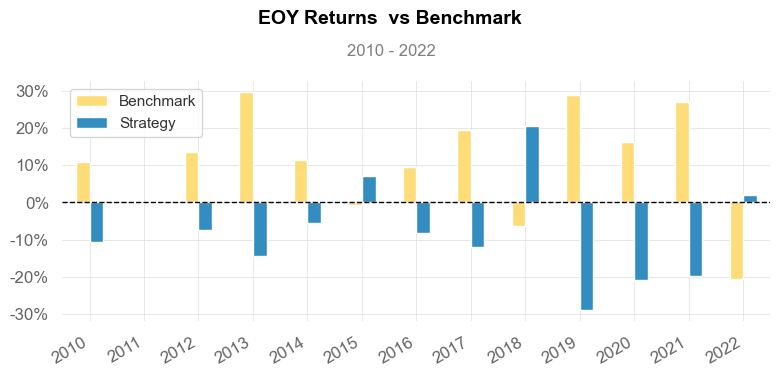

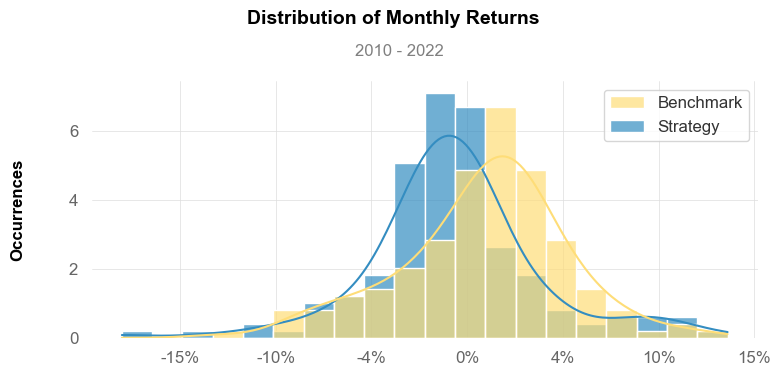

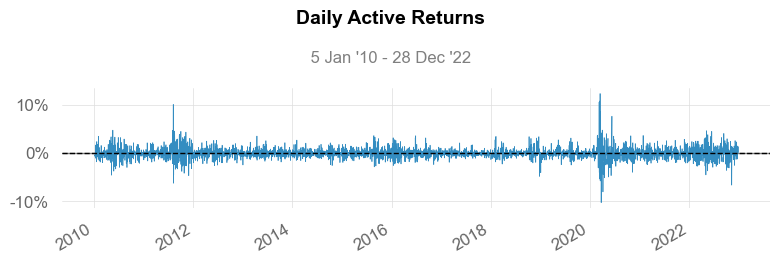

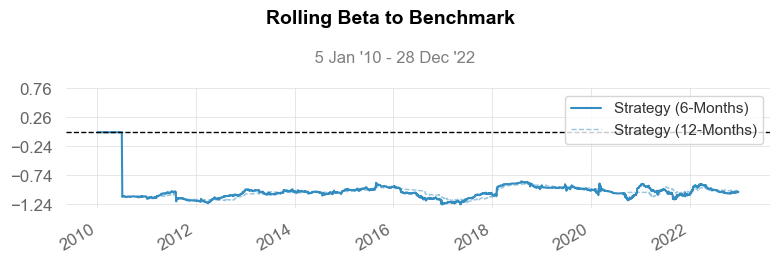

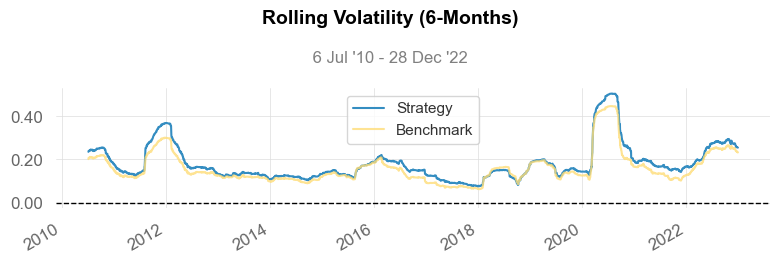

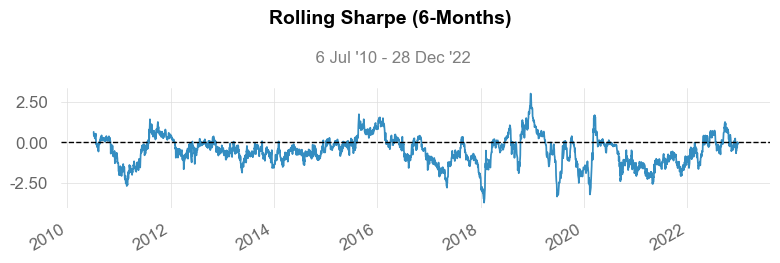

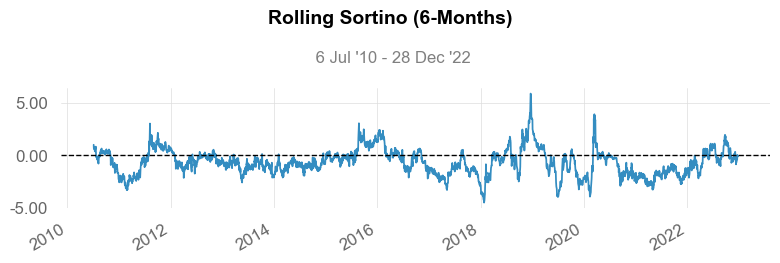

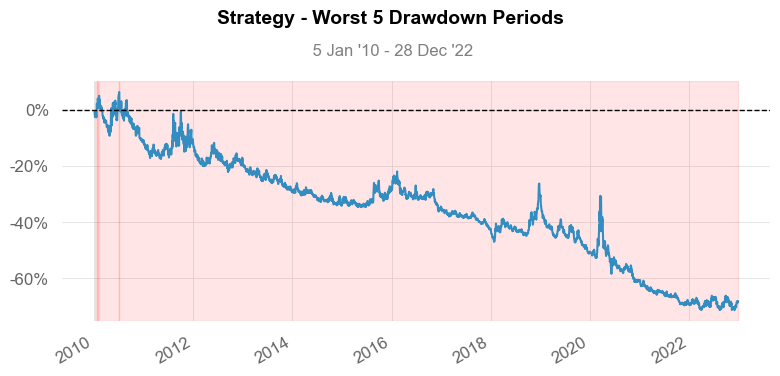

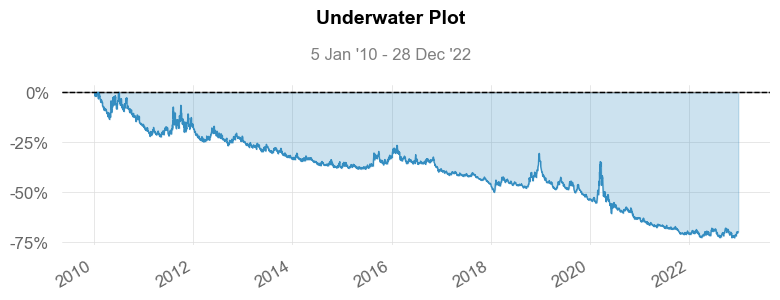

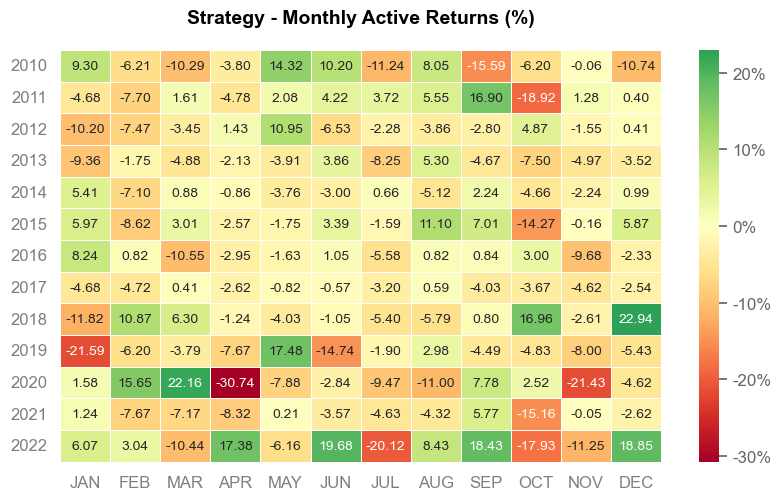

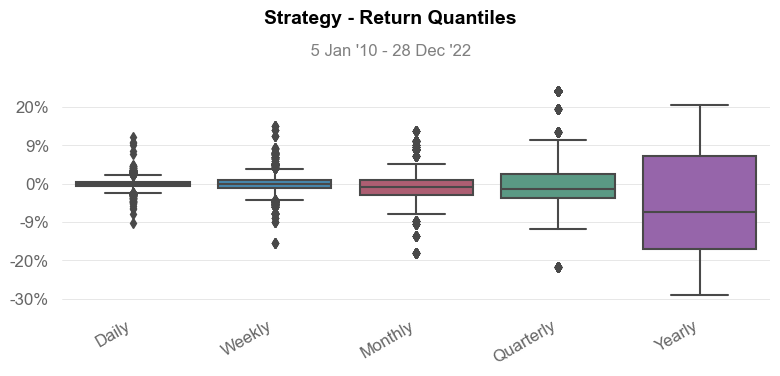

In [108]:
qs.reports.full(pred_return['totalRet'], "SPY")